In [2]:
import data_loading
import data_augment
import model_arch

2023-04-24 20:32:20.954506: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 20:32:21.050813: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-24 20:32:21.053199: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-24 20:32:21.053208: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [3]:
ins, outs = data_loading.load_data()

In [4]:
ins.shape

(350, 600, 100, 1)

In [5]:
outs.shape

(350, 600, 100, 1)

In [6]:
from skimage.io import imshow
from matplotlib import pyplot

In [7]:
import numpy as np

In [8]:
in_rows = ins.reshape((ins.shape[0] * ins.shape[1], ins.shape[2], ins.shape[3]))[:,:,0]

In [9]:
in_rows.shape

(210000, 100)

In [10]:
out_rows = outs.reshape((outs.shape[0] * outs.shape[1], outs.shape[2], outs.shape[3]))

In [11]:
out_rows.shape

(210000, 100, 1)

In [12]:
#out_sums = out_rows.sum(axis=(1,2))
present = (out_rows.sum(axis=(1,2)) > 0).astype(np.int32)

In [13]:
#present[present == 1] = 1
present[present == 0] = -1
print(-1 in present)

True


In [14]:
present.shape

(210000,)

In [15]:
from sklearn.svm import SVC

In [16]:
classifier = SVC(C=0.9)

In [17]:
normalized = (in_rows.transpose() / (np.sqrt((in_rows**2).sum(axis=1)  + 1e-7))).transpose()

In [18]:
normalized.shape

(210000, 100)

In [19]:
classifier.fit(normalized, present)

SVC(C=0.9)

In [25]:
import pickle
with open("presence.svm", "wb") as file:
    pickle.dump(classifier, file)
print("done")

done


In [26]:
with open("presence.svm", "rb") as file:
    class2 = pickle.load(file)
print("loaded")

loaded


In [30]:
p = classifier.predict(normalized[:200])

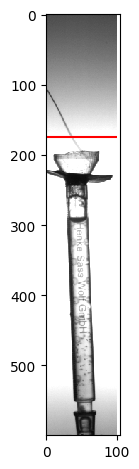

In [34]:
imshow(ins[0,:,:,0])
pyplot.hlines(175, 0, 100, color="red")
pyplot.show()